In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy.linalg as npl
np.set_printoptions(precision=2)

In [2]:
# generate data - M dimensions, N samples
N = 50
M = 2

np.random.seed(2)
X = np.random.randint(0, 20, N*M).astype(float)
X = X.reshape((N,M)) # NXM
X -= np.mean(X) # center
D = np.array([[npl.norm(X[i]-X[j]) for i in range(N)] for j in range(N)])
K = X@X.T # MXM
# print(D)

imap = {} # map array index to matrix index
i = 0
d = np.array([])
for r in range(N):
    for c in range(r+1, N):
        imap[i] = (r, c)
        d = np.append(d, D[r,c])
        i += 1
        
idx = np.argsort(d)
d = d[idx]
d, unique_idx = np.unique(d, return_index=True)
idx = idx[unique_idx]
# print(d)

# compare adjacent : len(d)-1 comparisons
S = [imap[idx[i]] + imap[idx[i+1]] for i in range(len(idx)-1)] 

# full order : len(d)C2 comparisons
# S = [imap[idx[i]] + imap[idx[j]] for i in range(len(idx)) for j in range(i+1,len(idx))] 

In [3]:
# inequality constraints
A = []
for (i,j,k,l) in S:
    a = np.zeros((N,N))
    a[k,k] += 1
    a[k,l] += -2
    a[l,l] += 1
    a[i,i] += -1
    a[i,j] += 2
    a[j,j] += -1
    A.append(a)
    
# problem
K_ = cp.Variable((N,N), symmetric=True) # gram matrix
E = cp.Variable((len(S),1), nonneg=True) # slack

diff = 1 # force difference between comparisons
gamma = 0.12 # reg param for rank

constraints = []
constraints += [K_ >> 0] # PSD
constraints += [cp.sum(K_) == 0] # center
constraints += [cp.trace(A[e]@K_) >= (diff - E[e]) for e in range(len(S))]

error = cp.sum(E)
obj = cp.Minimize(error + gamma*cp.trace(K_))
prob = cp.Problem(obj, constraints)
# prob.solve()

In [4]:
%time prob.solve()

CPU times: user 11.5 s, sys: 529 ms, total: 12 s
Wall time: 11.7 s


/usr/local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


119.1384816997622

In [5]:
# find best regularization parameter (gamma)
# gamma = cp.Parameter(nonneg=True)

# # trade-off - sum(E) vs tr(K_)
# sum_penalty = []
# tr_penalty = []
# K_vals = []
# gamma_vals = np.linspace(0.01, 0.5, 10) # Px1
# for val in gamma_vals:
#     gamma.value = val
#     prob.solve()
#     sum_penalty.append(error.value)
#     tr_penalty.append(cp.trace(K_).value)
#     K_vals.append(K_.value)

In [6]:
# # plot trade-off curve
# plt.figure(figsize=(12,4))
# plt.subplot(121)

# # not as helpful
# # plt.plot(tr_penalty, sum_penalty) 
# # plt.xlabel("trace")
# # plt.ylabel("slack")
# # plt.title("Trade-off curve")

# plt.plot(gamma_vals, tr_penalty, label='trace')
# plt.plot(gamma_vals, sum_penalty, label='sum')
# plt.xlabel("gamma")
# plt.ylabel("error")
# # plt.xscale('log')
# plt.title("Error vs gamma")
# plt.legend()


# # plot M+1 largest eigenvalues of K_ vs gamma
# plt.subplot(122)
# eigvals = np.array([npl.eigh(K_vals[i])[0][-M-1:] for i in range(len(gamma_vals))]) # Px(M+1)
# for i in range(1,M+2):
#     plt.plot(gamma_vals, eigvals[:,-i], label='%d'%(i))    
# # plt.xscale('log')
# plt.xlabel("gamma")
# plt.ylabel("eigenvalues")
# plt.title("Eigenvalues of K vs gamma")
# plt.legend()

In [7]:
# np.array([constraints[i].value() for i in range(2,len(S))]).T

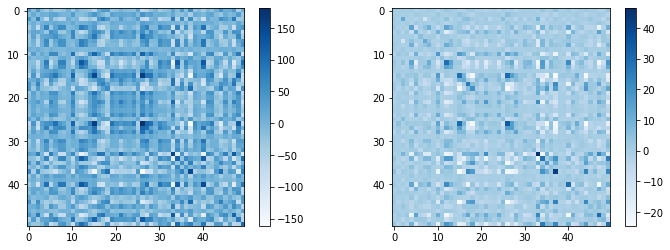

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(K, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.subplot(122)
plt.imshow(K_.value, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [9]:
U, V = npl.eigh(K_.value)

print(npl.eigh(K)[0])
print(npl.eigh(K_.value)[0])

U = U[-M:]
V = V[-M:]

x1 = X
x2 = (np.diag(U**0.5)@V).T

# rescale?
# U *= np.sqrt(np.sum(npl.eigh(K)[0][-2:]**2))/np.sqrt(np.sum(U**2))
X_ = (np.diag(U**0.5)@V).T # NxM

print(npl.eigh(K)[0][-2:])
print(U)

[-3.55e-13 -3.20e-13 -2.92e-13 -2.16e-13 -1.98e-13 -1.69e-13 -1.68e-13
 -1.49e-13 -1.37e-13 -1.35e-13 -1.07e-13 -1.05e-13 -8.64e-14 -8.23e-14
 -7.98e-14 -5.77e-14 -5.74e-14 -4.81e-14 -4.31e-14 -2.93e-14 -2.17e-14
 -1.97e-14 -6.05e-15 -2.77e-15 -5.20e-16  1.21e-15  5.09e-15  9.36e-15
  1.47e-14  1.90e-14  2.83e-14  3.80e-14  3.81e-14  4.08e-14  6.70e-14
  7.30e-14  8.13e-14  9.35e-14  9.69e-14  1.26e-13  1.31e-13  1.51e-13
  1.71e-13  1.81e-13  1.96e-13  2.30e-13  2.89e-13  3.13e-13  1.42e+03
  1.55e+03]
[-6.96e-05 -5.38e-05 -5.16e-05 -2.80e-05 -2.48e-05 -2.32e-05 -2.13e-05
 -1.77e-05 -1.55e-05 -1.38e-05 -1.19e-05 -1.09e-05 -8.68e-06 -5.86e-06
 -5.63e-06 -4.60e-06 -4.25e-06 -3.58e-06 -2.66e-06 -1.13e-07  7.56e-10
  3.27e-07  1.01e-06  2.44e-06  2.86e-06  3.93e-06  5.34e-06  6.98e-06
  8.79e-06  1.14e-05  1.26e-05  1.40e-05  1.76e-05  2.02e-05  2.52e-05
  3.05e-05  3.30e-05  3.65e-05  3.84e-05  4.63e-05  5.43e-05  7.12e-05
  7.90e+00  1.31e+01  2.53e+01  3.27e+01  4.78e+01  6.99e+01  1.9

In [10]:
# new distance matrix
D_ = np.array([[npl.norm(X_[i]-X_[j]) for i in range(N)] for j in range(N)])

# check if ordering is preserved
# based on distance matrix from positions
D_before = np.zeros(len(S))
D_after = np.zeros(len(S))

# based on gram matrix
K_before = np.zeros(len(S))
K_after = np.zeros(len(S))

for s in range(len(S)):
    (i,j,k,l) = S[s]
    D_before[s] = D[i,j] <= D[k,l]
    D_after[s] = D_[i,j] <= D_[k,l]
    K_before[s] = np.trace(A[s]@K) >= 0
    K_after[s] = np.trace(A[s]@K_.value) >= 0

# fraction of orderings preserved
D_preserved = (len(S) - np.count_nonzero(D_before-D_after))/len(S)
K_preserved = (len(S) - np.count_nonzero(K_before-K_after))/len(S)

print("%.3f"%(len(S)/(N*N-N)))
print("%.3f"%(D_preserved))
print("%.3f"%(K_preserved))

0.063
0.523
0.923


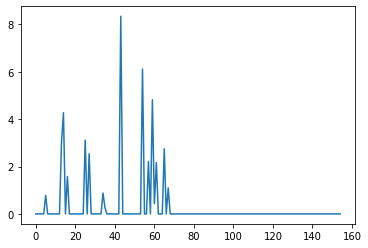

In [11]:
plt.plot(E.value.reshape(-1))